In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, MaxPool2D,
    Conv2DTranspose, Concatenate, Input, Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Set seeds for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Hyperparameters
batch_size = 2  # Reduce the batch size
epochs = 50
height, width = 640, 640  # Update the height and width to 640x640
input_shape = (height, width, 3)
lr = 1e-4  # Learning rate

# Define convolution block
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)  # Add Dropout layer
    return x

# Define encoder block
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Define decoder block
def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters)
    return x

# Build U-Net model for segmentation
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)  # Reduce number of filters
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    bl = conv_block(p4, 512)

    dl = decoder_block(bl, s4, 256)
    d2 = decoder_block(dl, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid", name="segmentation")(d4)
    model = Model(inputs, segmentation_output, name="UNET")
    return model

# Define paths and create directories
data_dir = r"/home/user/unet/data"
files_dir = data_dir
plots_dir = os.path.join(files_dir, "plots")  # Directory to save plots

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created.")
    else:
        print(f"Directory {directory} already exists.")

create_dir(files_dir)
create_dir(plots_dir)  # Create plots directory
model_file = os.path.join(files_dir, "unet-model.keras")
log_file = os.path.join(files_dir, "log.csv")

# Function to load and split data
def load_data(data_dir):
    def get_data_paths(subset):
        images = sorted(glob(os.path.join(data_dir, subset, "*.png")))
        masks = sorted(glob(os.path.join(data_dir, subset, "masks", "*.png")))
        return images, masks
    
    train_x, train_y = get_data_paths("train")
    valid_x, valid_y = get_data_paths("val")
    test_x, test_y = get_data_paths("test")

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# Functions to read images and masks
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    return x.astype(np.float32)

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (width, height))
    x = x / 255.0
    x = np.expand_dims(x, axis=-1)
    x = np.where(x > 0.5, 1, 0)  # Ensure binary masks
    return x.astype(np.float32)

# TensorFlow parsing and dataset functions
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([height, width, 3])
    y.set_shape([height, width, 1])
    return x, y

def tf_dataset(x, y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Load the dataset
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(data_dir)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

# Create datasets
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)
test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

for x, y in valid_dataset:
    print(x.shape, y.shape)
    break

# Data augmentation generators
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

def data_generator(image_paths, mask_paths, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            img_batch = []
            mask_batch = []
            for img_path, mask_path in zip(image_paths[start:end], mask_paths[start:end]):
                img = cv2.imread(img_path)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = np.expand_dims(mask, axis=-1)  # Expand dims to ensure 4D shape
                img = cv2.resize(img, (width, height))
                mask = cv2.resize(mask, (width, height))
                img = img / 255.0
                mask = mask / 255.0
                img_batch.append(img)
                mask_batch.append(mask)
            img_batch = np.array(img_batch)
            mask_batch = np.array(mask_batch)
            mask_batch = np.expand_dims(mask_batch, axis=-1)  # Ensure mask_batch is 4D
            seed = np.random.randint(1e6)
            img_gen = image_datagen.flow(img_batch, batch_size=batch_size, seed=seed)
            mask_gen = mask_datagen.flow(mask_batch, batch_size=batch_size, seed=seed)
            yield (next(img_gen), next(mask_gen))

# Update training and validation data generators
train_generator = data_generator(train_x, train_y, batch_size)
valid_generator = data_generator(valid_x, valid_y, batch_size)

# Build and compile the model
model = build_unet(input_shape)
opt = Adam(learning_rate=lr)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

# Callbacks for training
callbacks = [
    ModelCheckpoint(model_file, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    callbacks=callbacks,
    steps_per_epoch=len(train_x) // batch_size,
    validation_steps=len(valid_x) // batch_size
)

# Save training history plots
def plot_history(history, plots_dir):
    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(plots_dir, 'model_accuracy.png'))
    plt.close()

    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(os.path.join(plots_dir, 'model_loss.png'))
    plt.close()

plot_history(history, plots_dir)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save evaluation results
with open(os.path.join(plots_dir, 'evaluation_results.txt'), 'w') as f:
    f.write(f"Test Loss: {test_loss}\n")
    f.write(f"Test Accuracy: {test_accuracy}\n")


2024-07-18 10:37:33.149988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 10:37:33.501289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 10:37:33.616737: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 10:37:33.650234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 10:37:33.903093: I tensorflow/core/platform/cpu_feature_guar

1 Physical GPUs, 1 Logical GPUs
Directory /home/user/unet/data already exists.
Directory /home/user/unet/data/plots created.
Train: 401 - 0
Valid: 86 - 0
Test: 86 - 0


ValueError: Dimensions 401 and 0 are not compatible

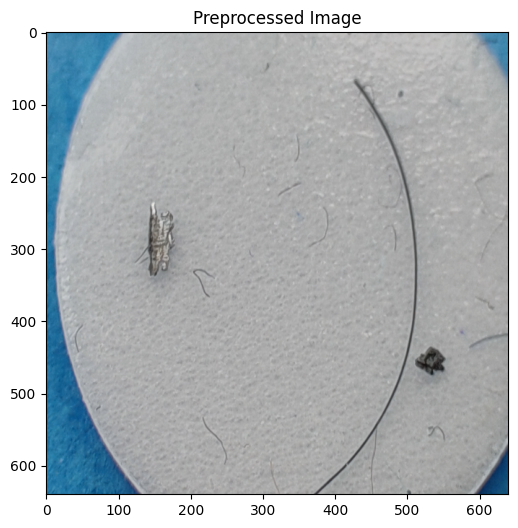

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
Predicted mask range: 0.022757528349757195 to 0.5034273266792297


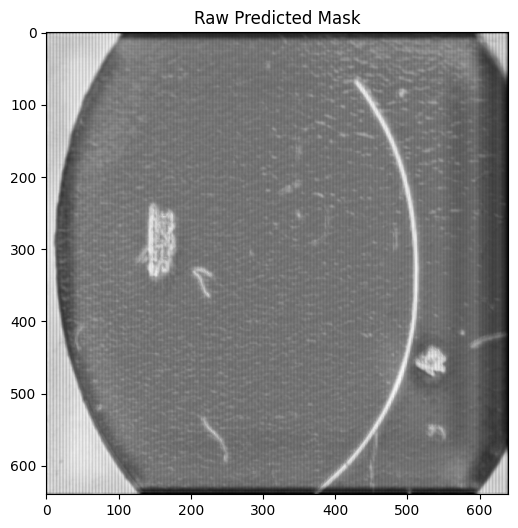

Post-process mask range before thresholding: 0.022757528349757195 to 0.5034273266792297
Post-process mask range after thresholding: 0 to 255


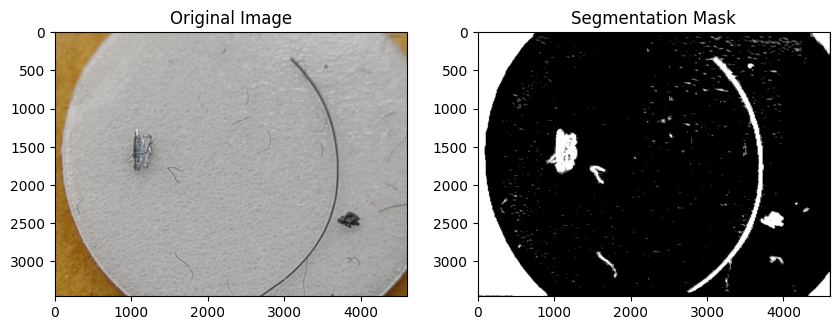

In [7]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Set the paths
model_path = r"/home/user/unet/runs/train3-with-aug/unet-model.keras"
image_path = r"/home/user/unet/my-mobile-images/1 (19).jpg"  # Update with the path to your image
output_path = r"/home/user/unet/my-mobile-images/detected/detect_1_(19).png"  # Path to save the output mask

# Load the trained model
model = load_model(model_path)

# Define the image dimensions (should match the dimensions used during training)
height, width = 640, 640

# Function to preprocess the input image
def preprocess_image(image_path, height, width):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (width, height))
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to post-process the output mask
def postprocess_mask(mask, original_image_path, output_path, threshold=0.3):
    mask = mask.squeeze()  # Remove batch dimension
    print(f"Post-process mask range before thresholding: {mask.min()} to {mask.max()}")
    mask = (mask > threshold).astype(np.uint8) * 255  # Adjusted threshold
    print(f"Post-process mask range after thresholding: {mask.min()} to {mask.max()}")
    original_image = cv2.imread(original_image_path, cv2.IMREAD_COLOR)
    original_height, original_width = original_image.shape[:2]
    mask = cv2.resize(mask, (original_width, original_height))  # Resize to original image size
    cv2.imwrite(output_path, mask)  # Save the mask
    return mask

# Preprocess the image
image = preprocess_image(image_path, height, width)

# Visualize the preprocessed image
plt.figure(figsize=(6, 6))
plt.title("Preprocessed Image")
plt.imshow(image.squeeze())
plt.show()

# Predict the segmentation mask
predicted_mask = model.predict(image)

# Check the range of predicted mask values
print(f"Predicted mask range: {predicted_mask.min()} to {predicted_mask.max()}")

# Visualize the raw predicted mask
plt.figure(figsize=(6, 6))
plt.title("Raw Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap="gray")
plt.show()

# Post-process and save the mask
mask = postprocess_mask(predicted_mask, image_path, output_path)

# Display the original image and the mask
original_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
mask_image = cv2.imread(output_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Segmentation Mask")
plt.imshow(mask_image, cmap="gray")

plt.show()
